In [1]:
import pandas as pd
import numpy as np
import ModelMaker as mm

In [2]:
lst = [11,12,13,14,15,16,17,18,19,20,21]
df_goalie = pd.read_csv('data/PBP/EH_GOALIE_11-21.csv')
df_goalie.Player = df_goalie.Player.str.replace('.',' ',regex=True).str.title()
df_import = pd.DataFrame()
for year in lst:
    print(year)
    stats   = pd.read_csv(f'data/PBP/ready_to_model/with_players/{year-1}_{year}_pbp_cleaned.csv')
    goalies = df_goalie[df_goalie.Season == f'{year-1}-{year}'].copy()
    gsax_dict = dict(zip(goalies.Player, goalies.GSAx))
    stats.home_goalie = stats.home_goalie.apply(lambda x:gsax_dict[x])
    stats.away_goalie = stats.away_goalie.apply(lambda x:gsax_dict[x])
    df_import = df_import.append(stats)

11
12
13
14
15
16
17
18
19
20
21


In [3]:
df_import['goalie_strength'] = np.where((df_import.is_home ==1),df_import.home_goalie,df_import.away_goalie)
drp_lst = ['home_on_1','home_on_2','home_on_3','home_on_4',
           'home_on_5','home_on_6','home_on_7','home_goalie',
           'away_on_1','away_on_2','away_on_3','away_on_4',
           'away_on_5','away_on_6','away_on_7','away_goalie',]
df_model = df_import.drop(drp_lst, axis=1)
#df_original = df_model.drop(['goalie_strength'],axis=1)

In [20]:
model_goalie = mm.run_XGB(df_model)

Running XGB model, please be patient
Fitting the test data to the model
The Log loss is 0.19392
The R^2 value is 0.0599


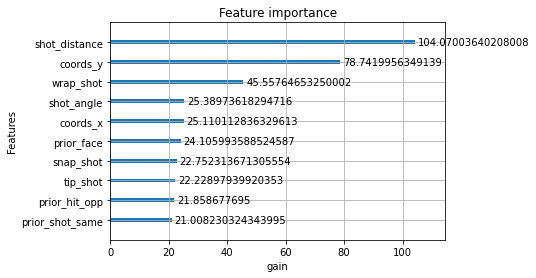

In [23]:
mm.plot_xgb(model_goalie, type='gain')

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [5]:
X = df_model.drop(['is_goal'], axis=1).to_numpy()
y = df_model.is_goal.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=101)

In [9]:
xgb_reg = xgb.XGBRegressor(objective='binary:logistic',
                           eval_metric = 'logloss',
                           eta = .068,
                           subsample = .78,
                           colsample_bytree = .76,
                           min_child_weight = 9,
                           max_delta_step = 5,
                           nthread = 4)

selector = RFECV(xgb_reg, step=1, min_features_to_select=1, cv=10, scoring='neg_mean_absolute_error',
                 verbose=1,n_jobs=-2)
selector = selector.fit(X_train,y_train)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


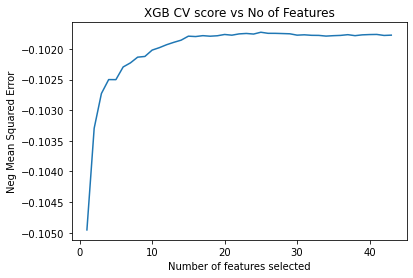

In [11]:
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Neg Mean Squared Error")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [12]:
rank = selector.ranking_

In [13]:
print(rank)

[ 6  9  4  7  1  1  3  1  1  1  1 17 18  1  1 12 10 15  1  8  1  1  1  1
  1  1  1  2 11  1  1 16  1  1 19  1  1 14 13  1  1  1  5]


In [14]:
df_model.columns

Index(['Unnamed: 0', 'game_period', 'game_seconds', 'is_home', 'coords_x',
       'coords_y', 'coords_x_last', 'coords_y_last', 'shot_distance',
       'shot_angle', 'state_5v5', 'state_5v4', 'score_down_4', 'score_down_3',
       'score_down_2', 'score_down_1', 'score_even', 'score_up_1',
       'score_up_2', 'score_up_3', 'wrist_shot', 'deflected_shot', 'tip_shot',
       'slap_shot', 'backhand_shot', 'snap_shot', 'prior_shot_same',
       'prior_miss_same', 'prior_shot_opp', 'prior_miss_opp', 'prior_give_opp',
       'prior_take_opp', 'prior_hit_opp', 'prior_face', 'state_5v3',
       'score_up_4', 'wrap_shot', 'prior_block_same', 'prior_block_opp',
       'prior_give_same', 'prior_take_same', 'prior_hit_same', 'is_goal',
       'goalie_strength'],
      dtype='object')

In [18]:
selector.support_

array([False, False, False, False,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
        True, False, False,  True,  True,  True, False])